In [ ]:
# conda create --name sig_verif_1 python=3.8.19
# conda activate sig_verif_1
# conda install -c conda-forge numpy=1.24.4 pandas=1.1.4 matplotlib=3.3.3 pillow=8.1.1
# https://pytorch.org/get-started/locally/
# conda install -c conda-forge notebook
# conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [ ]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
import sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
# from PIL import Image
import PIL.ImageOps
import os
import json
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from torch.nn.functional import cosine_similarity

from skimage.exposure import match_histograms
from PIL import ImageEnhance, ImageStat, ImageOps, Image

from torchviz import make_dot
# !pip install netron
# import netron, onnx

In [2]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv

In [3]:
# just to show csv data
df = pd.read_csv(training_csv, header=None)
df.columns = ["image1", "image2", "label"]
df

,image1,image2,label
0,034/01_034.png,034_forg/01_0103034.PNG,1
1,034/01_034.png,034_forg/01_0110034.PNG,1
2,034/01_034.png,034_forg/01_0120034.PNG,1
3,034/01_034.png,034_forg/02_0103034.PNG,1
4,034/01_034.png,034_forg/02_0110034.PNG,1
...,...,...,...
29921,046/09_046.png,046/11_046.png,0
29922,046/09_046.png,046/12_046.png,0
29923,046/10_046.png,046/11_046.png,0
29924,046/10_046.png,046/12_046.png,0


In [3]:
# from skimage.exposure import match_histograms

def match_intensity(img0, img1):
    """
    Matches the intensity distribution of img1 to img0 (reference image).
    Only modifies the gray (black) channel.
    """
    # Match histogram of img1 to img0
    matched_img1 = match_histograms(img1.cpu().numpy(), img0.cpu().numpy(), channel_axis=False)  #multichannel

    # Convert back to tensor
    matched_img1 = torch.tensor(matched_img1, dtype=torch.float32)

    return img0, matched_img1


def increase_contrast(image, factor=2.0):
    """
    Increase the contrast of an image.
    :param factor: Factor by which to increase the contrast (1.0 means no change)
    """
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)

In [4]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None, contrast_factor=2.0):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv, header=None)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform
        self.contrast_factor = contrast_factor  # Store contrast factor

    def __getitem__(self, index):
        
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)

        img0 = img0.convert("L")  #grayscale
        img1 = img1.convert("L")

        # Increase contrast
        img0 = increase_contrast(img0, self.contrast_factor)
        img1 = increase_contrast(img1, self.contrast_factor)

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

            # Match intensities between the two images
            img0, img1 = match_intensity(img0, img1)

            # Clip image values to [0, 1]
            img0 = torch.clamp(img0, 0, 1)
            img1 = torch.clamp(img1, 0, 1)
        # ----------------------------------------------------------------------------
        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
            # image1_path,  # Returns image1 path #####
            # image2_path,  # Returns image2 path
        )

    def __len__(self):
        return len(self.train_df)

In [5]:
transform=transforms.Compose(
        [transforms.Resize((105, 105)),
         transforms.ToTensor(),
        #  transforms.Grayscale(num_output_channels=1),
         ])

# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transform,
    contrast_factor=2,)   # contrast_factor=2.5

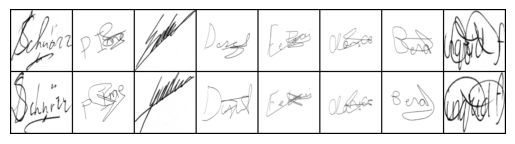

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [48]:
# Viewing a sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)

imshow(torchvision.utils.make_grid(concatenated))  #concatenated
print(example_batch[2].numpy())

In [ ]:
# To check filename for the first image in each pair. You should activate 3rd & 4th returns in SiameseDataset
    
# first_column_filenames = example_batch[3]
# print("First column image filenames:")
# for filename in first_column_filenames:
#     print(filename)

In [ ]:
# Architech
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.BatchNorm2d(96),         # reduces number of epochs
            nn.ReLU(inplace=True),      # activation function
            nn.MaxPool2d(3, stride=2),  # reduces spatial size

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),         # prevents overfitting

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.3),
        )


        # Dynamically calculate the input size for fc1
        self.flattened_size = self._get_flattened_size()


        self.fc1 = nn.Sequential(                    #stacked neurons
            nn.Linear(self.flattened_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True)
            # nn.Linear(128, 2)
        )

        # Add a final layer for classification
        self.fc_classification = nn.Sequential(
            nn.Linear(1*128, 1),  #1, 3*128, Binary classification (forged/genuine)
            nn.Sigmoid()  # Output probability
        )


    def _get_flattened_size(self):
        # Use a dummy input to calculate the flattened size
        dummy_input = torch.zeros(1, 1, 105, 105)  # Assuming input images are 105x105
        output = self.cnn1(dummy_input)
        return output.view(1, -1).size(1)

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size(0), -1)  # Flatten
        output = self.fc1(output)
        return output

    # def forward(self, input1, input2):
    #     output1 = self.forward_once(input1)
    #     output2 = self.forward_once(input2)
    #     return output1, output2
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # similarity = F.pairwise_distance(output1, output2)
        # prob = self.fc_classification(similarity.unsqueeze(1))  # Pass similarity to the classifier

        combined_features = torch.abs(output1 - output2)  # Just absolute difference
        # combined_features = torch.cat((output1, output2, torch.abs(output1 - output2)), dim=1) #Concatenation + Absolute Difference
        prob = self.fc_classification(combined_features)

        return prob

In [1]:
# import netron, onnx

# # Load your trained model
# model = torch.load("content/new_data_20_epochs.pt", map_location="cpu")
# model.eval()

# # Create dummy input (two separate inputs for Siamese Network)
# input1 = torch.randn(1, 1, 105, 105)
# input2 = torch.randn(1, 1, 105, 105)

# # Forward pass
# output = model(input1, input2)

# torch.onnx.export(model, 
#                   (input1, input2),  # Tuple of two inputs
#                   "siamese_network.onnx",
#                   input_names=["input1", "input2"],
#                   output_names=["output"],
#                   opset_version=11)

# netron.start("siamese_network.onnx")

In [49]:
# Load train dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,  #.py file more workers (total=20)
                        batch_size=config.batch_size)

if torch.cuda.is_available():
  device = 'cuda'
  print('Yes, cuda available and enabled.')
else:
  device = 'cpu'
  print('No cuda, cpu enabled.')

Yes, cuda available and enabled.


# Training

Epoch 1 | Loss: 0.6801 | Accuracy: 0.7122 | Learning Rate: 0.001
Epoch 2 | Loss: 0.5583 | Accuracy: 0.7245 | Learning Rate: 0.001
Epoch 3 | Loss: 0.5176 | Accuracy: 0.7302 | Learning Rate: 0.001
Epoch 4 | Loss: 0.4755 | Accuracy: 0.7576 | Learning Rate: 0.001
Epoch 5 | Loss: 0.4359 | Accuracy: 0.7883 | Learning Rate: 0.001
Epoch 6 | Loss: 0.3855 | Accuracy: 0.8189 | Learning Rate: 0.001
Epoch 7 | Loss: 0.3448 | Accuracy: 0.8428 | Learning Rate: 0.001
Epoch 8 | Loss: 0.3163 | Accuracy: 0.8577 | Learning Rate: 0.001
Epoch 9 | Loss: 0.2967 | Accuracy: 0.8655 | Learning Rate: 0.001
Epoch 10 | Loss: 0.2918 | Accuracy: 0.8691 | Learning Rate: 0.001
Epoch 11 | Loss: 0.2792 | Accuracy: 0.8764 | Learning Rate: 0.001
Epoch 12 | Loss: 0.2635 | Accuracy: 0.8849 | Learning Rate: 0.001
Epoch 13 | Loss: 0.2667 | Accuracy: 0.8838 | Learning Rate: 0.001
Epoch 14 | Loss: 0.2607 | Accuracy: 0.8876 | Learning Rate: 0.001
Epoch 15 | Loss: 0.2553 | Accuracy: 0.8913 | Learning Rate: 0.001
Epoch 16 | Loss: 0.

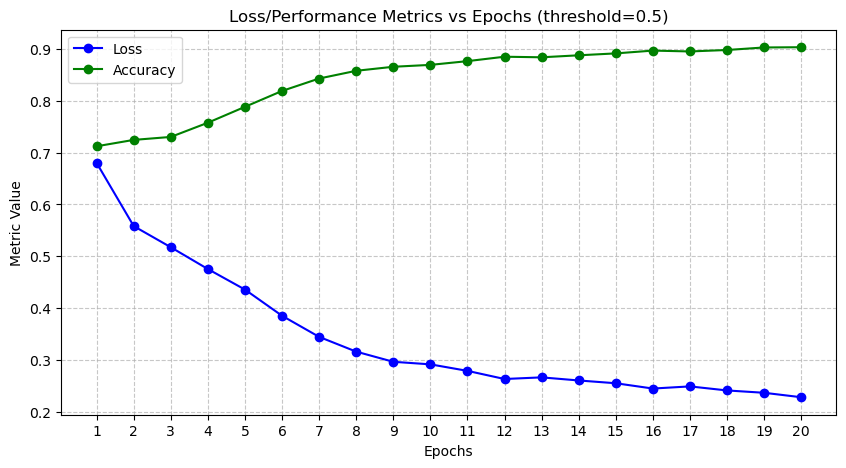

In [15]:
# Declare Siamese Network
net = SiameseNetwork().to(device)

# Decalre Loss Function
criterion = nn.BCELoss()  #Binary Cross-Entropy Loss

# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)   # torch.optim.SGD
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

losses = []  # To store average loss per epoch
accuracies = []  # To store accuracy per epoch
thresh = 0.5

for epoch in range(1, config.epochs+1):
    net.train()
    loss_sum = 0
    correct_predictions = 0
    total_samples = 0

    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()

        output = net(img0, img1)  # Forward pass
        loss = criterion(output, label.float())  # Calculate BCELoss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

        loss_sum += loss.item()
        # Compute accuracy
        predictions = (output > thresh).float()
        correct_predictions += (predictions == label).sum().item()
        total_samples += label.size(0)

    avg_loss = loss_sum / len(train_dataloader)
    accuracy = correct_predictions / total_samples

    # Save metrics
    losses.append(avg_loss)
    accuracies.append(accuracy)

    # Learning rate adjustment
    scheduler.step(avg_loss)

    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | Learning Rate: {optimizer.param_groups[0]['lr']}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label='Loss', color='blue', marker='o')
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', color='green', marker='o')
plt.title(f'Loss/Performance Metrics vs Epochs (threshold={thresh})')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.xticks(range(1, len(losses) + 1))  # Set x-ticks as epochs
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

model = net

torch.save(model, f"content/new_data_20_epochs.pt")

___

# Inference

In [ ]:
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load('model.pt'))

model = torch.load("content/new_data_20_epochs.pt")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"cuda if GPU else CPU: {device}")
model.to(device)

model.eval()
'''
important for layers like dropout or batch normalization;
but model.train() activates train mode
'''

# Load the test dataset
test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transform,
    contrast_factor=2,)

test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=True)  #num_workers=8

cuda if GPU else CPU: cuda


C:\Users\diagl.DIAGLC-DEV-02\AppData\Local\Temp\ipykernel_17992\1760535598.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("content/new_data_20_epochs

Pairs Of Signatures


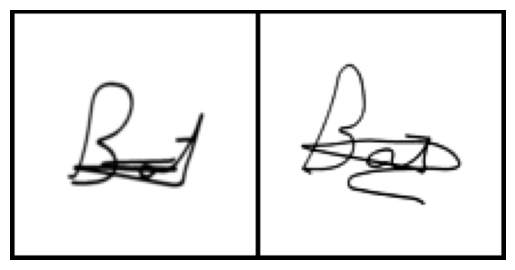

Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


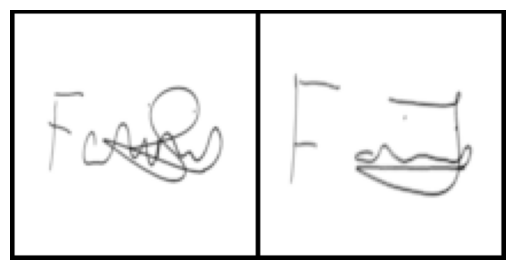

Actual Label: Forged
Predicted: Original
-------------------------------------------------------------------


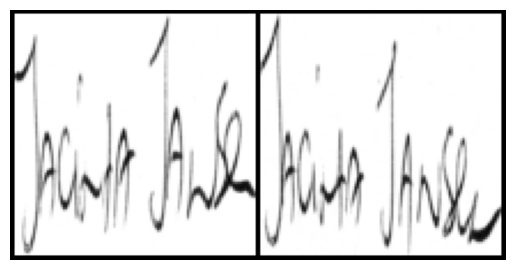

Actual Label: Original
Predicted: Forged
-------------------------------------------------------------------


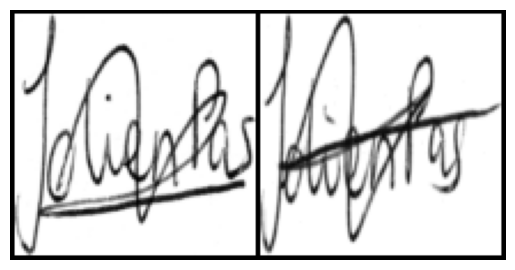

Actual Label: Original
Predicted: Forged
-------------------------------------------------------------------


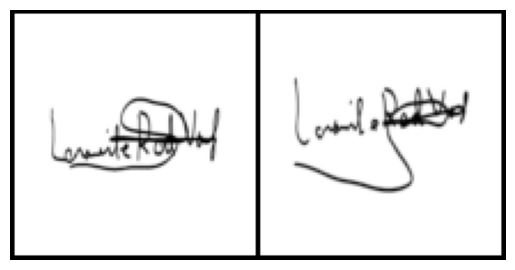

Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


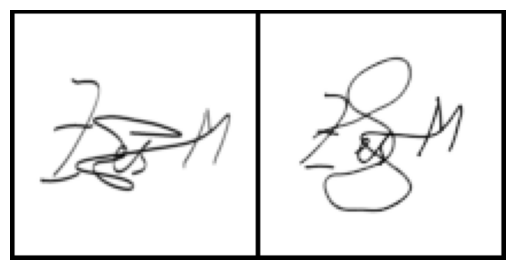

Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


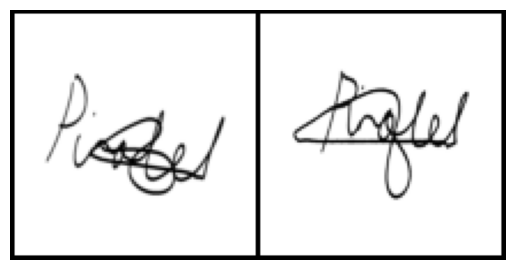

Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


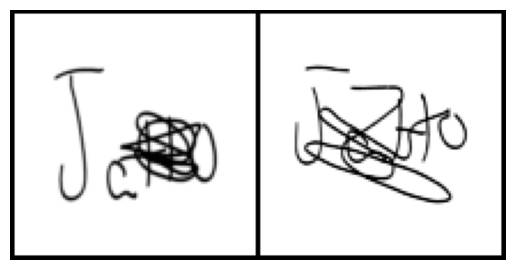

Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


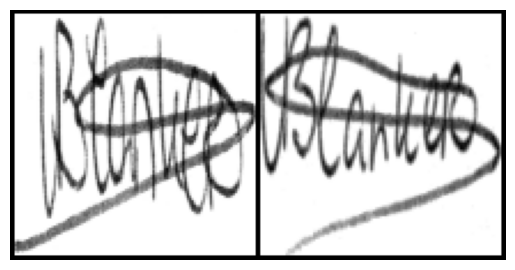

Actual Label: Forged
Predicted: Forged
-------------------------------------------------------------------


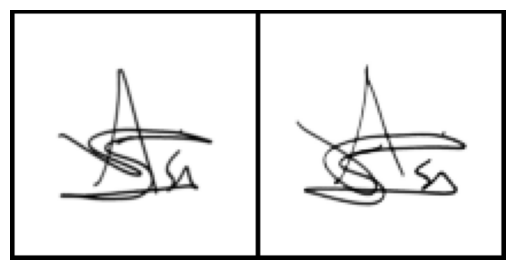

Actual Label: Original
Predicted: Forged
-------------------------------------------------------------------


In [67]:
threshold = 0.50  ### Adjust
criterion = nn.BCELoss()

print("Pairs Of Signatures")

count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)

    output = model(x0.to(device),x1.to(device))
    output = output.squeeze().item()  # Convert tensor to scalar

    if label.item() == 0:
        label_text = "Original"
    else:
        label_text = "Forged"

    # Calculate loss for the pair
    label_tensor = label.to(device).float().view(-1)  # Ensure correct shape and type
    loss = criterion(torch.tensor([output], device=device), label_tensor).item()

    prediction = "Forged" if output > threshold else "Original"

    imshow(torchvision.utils.make_grid(concat))
    print(f"Actual Label: \033[1m{label_text}\033[0m")
    print(f"Predicted: \033[1m{prediction}\033[0m")   #reset: \033[0m
    print("-" * 67)
    count = count + 1
    if count == 10:
        break

# Performance Metrics for testing dataset

In [52]:
# Set threshold for binary classification
threshold = 0.50  # Adjust this;

# Initialize lists to store predictions and labels
all_predictions = []
all_labels = []

# Switch model to evaluation mode
model.eval()

print("Pairs of Signatures")
L_data_test = len(test_dataloader)

# Disable gradient computation during evaluation
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Forward pass
        output = model(img0, img1)  # Get similarity probability
        
        # Predict based on threshold
        prediction = (output > threshold).float()  # 1 for "Forged", 0 for "Genuine"

        # Store predictions and labels
        all_predictions.extend(prediction.cpu().numpy().flatten().tolist())   
        all_labels.extend(label.cpu().numpy().flatten().tolist())

# Convert lists to tensors for metrics calculation
all_predictions = torch.tensor(all_predictions)
all_labels = torch.tensor(all_labels)

# Calculate performance metrics
accuracy = accuracy_score(all_labels, all_predictions)
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, pos_label=1)
recall = recall_score(all_labels, all_predictions, pos_label=1)

# Specificity (True Negative Rate)
tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
specificity = tn / (tn + fp)

# F1 Score
f1 = f1_score(all_labels, all_predictions, pos_label=1)

# Print metrics
print(f"\nPerformance Metrics on Test Data ({L_data_test} pairs, Threshold = {threshold}):\n")
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}\n")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}\n")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix: TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}")


Pairs of Signatures

Performance Metrics on Test Data (7979 pairs, Threshold = 0.5):

Accuracy: 0.71
Balanced Accuracy: 0.59

Precision: 0.76
Recall (Sensitivity): 0.86
Specificity: 0.32

F1 Score: 0.81
Confusion Matrix: TN = 734, FP = 1533, FN = 801, TP = 4911


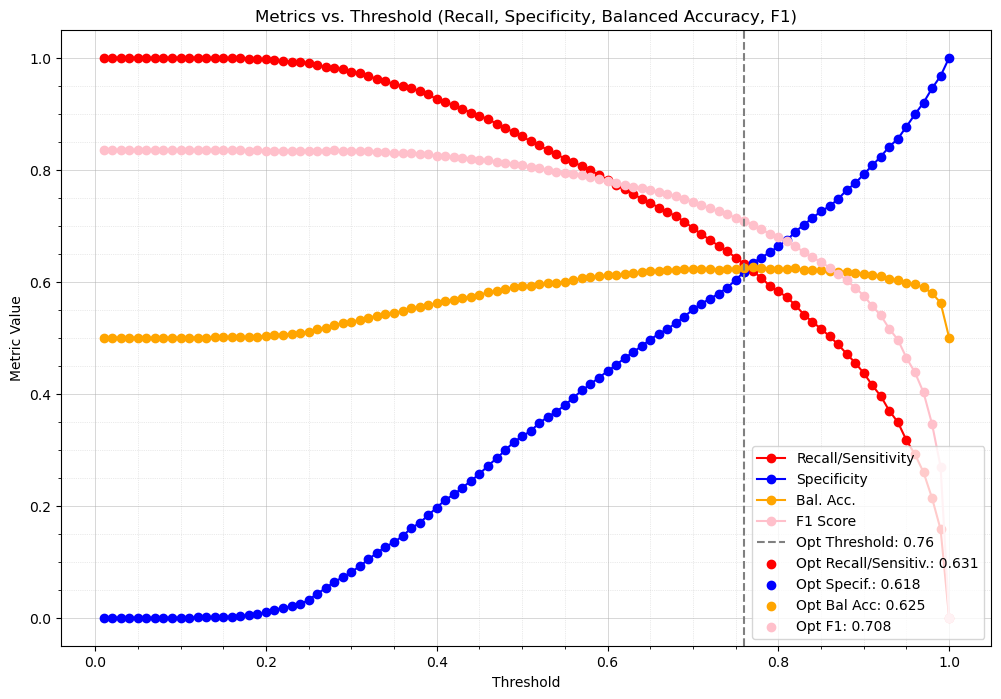

Optimum Threshold: 0.76
Recall/Sensitivity at Optimum: 0.631
Specificity at Optimum: 0.618
Balanced Accuracy at Optimum: 0.625
F1 Score at Optimum: 0.708


In [ ]:
from sklearn.metrics import confusion_matrix

# Initialize lists to store metrics
thresholds = torch.arange(0.01, 1.01, 0.01).tolist()
recalls = []
specificities = []
balanced_accuracies = []
f1_scores = []

# Ensure model is in evaluation mode
model.eval()

# Disable gradient computation during evaluation
all_predictions = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Forward pass
        output = model(img0, img1)  # Get similarity probability

        # Store predictions and labels
        all_labels.extend(label.cpu().numpy())
        all_predictions.append(output.cpu().numpy())

# Convert predictions and labels to NumPy arrays
all_predictions = np.concatenate(all_predictions)  # Flatten to 1D array
all_labels = np.array(all_labels)

# Loop over thresholds to calculate metrics
for threshold in thresholds:
    # Generate predictions based on the threshold
    predictions = (all_predictions > threshold).astype(float)  # 1 for "Forged", 0 for "Genuine"

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(all_labels, predictions).ravel()

    # Recall (Sensitivity)
    recall = tp / (tp + fn)

    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp)

    # Balanced Accuracy
    balanced_acc = (recall + specificity) / 2

    # F1 Score
    f1 = (2 * tp) / (2 * tp + fp + fn)  # harmonic mean of Precision and Recall = 2.precision.recall/(precision+recall)

    # Append metrics
    recalls.append(recall)
    specificities.append(specificity)
    balanced_accuracies.append(balanced_acc)
    f1_scores.append(f1)

# Plot Recall, Specificity, Balanced Accuracy, and F1 Score
plt.figure(figsize=(12, 8))
plt.plot(thresholds, recalls, label="Recall/Sensitivity", marker='o', color='red')
plt.plot(thresholds, specificities, label="Specificity", marker='o', color='blue')
plt.plot(thresholds, balanced_accuracies, label="Bal. Acc.", marker='o', color='orange')
plt.plot(thresholds, f1_scores, label="F1 Score", marker='o', color='pink')

# Find and mark the optimum threshold (where Recall and Specificity are closest)
differences = [abs(r - s) for r, s in zip(recalls, specificities)]
optimum_index = differences.index(min(differences))
optimum_threshold = thresholds[optimum_index]
optimum_recall = recalls[optimum_index]
optimum_specificity = specificities[optimum_index]
optimum_balanced_acc = balanced_accuracies[optimum_index]
optimum_f1 = f1_scores[optimum_index]

plt.axvline(x=optimum_threshold, color='gray', linestyle='--', label=f"Opt Threshold: {optimum_threshold:.2f}")
plt.scatter(optimum_threshold, optimum_recall, color='red', label=f"Opt Recall/Sensitiv.: {optimum_recall:.3f}")
plt.scatter(optimum_threshold, optimum_specificity, color='blue', label=f"Opt Specif.: {optimum_specificity:.3f}")
plt.scatter(optimum_threshold, optimum_balanced_acc, color='orange', label=f"Opt Bal Acc: {optimum_balanced_acc:.3f}")
plt.scatter(optimum_threshold, optimum_f1, color='pink', label=f"Opt F1: {optimum_f1:.3f}")

# Add labels, legend, and grid
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Threshold (Recall, Specificity, Balanced Accuracy, F1)")
plt.legend(loc="best")
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=0.5)
plt.minorticks_on()

# Show the plot
plt.show()

# Print optimum threshold and metrics
print(f"Optimum Threshold: {optimum_threshold:.2f}")
print(f"Recall/Sensitivity at Optimum: {optimum_recall:.3f}")
print(f"Specificity at Optimum: {optimum_specificity:.3f}")
print(f"Balanced Accuracy at Optimum: {optimum_balanced_acc:.3f}")
print(f"F1 Score at Optimum: {optimum_f1:.3f}")

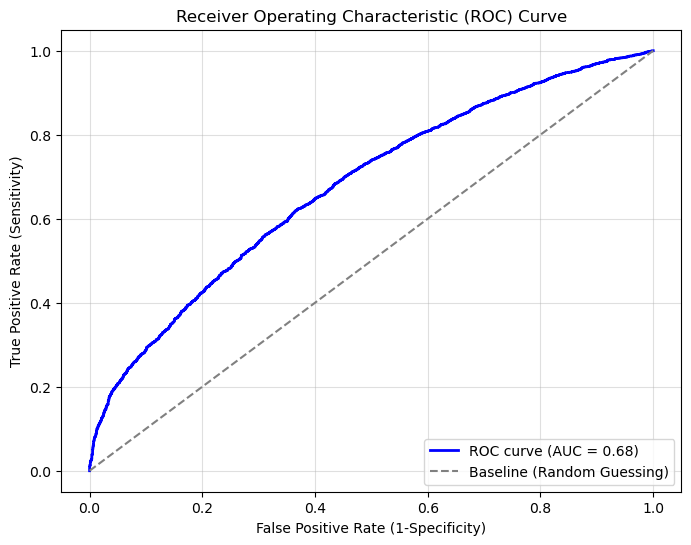

In [53]:
from sklearn.metrics import roc_curve, auc

# Initialize lists to store probs and labels
all_probs = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        x0, x1, label = data
        x0, x1, label = x0.to(device), x1.to(device), label.to(device)
        
        # Forward pass: our model outputs a probability already (due to Sigmoid)
        output = model(x0, x1)
        prob = output.squeeze().cpu().numpy()  # Convert to a scalar or 1D numpy array
        
        # Store probability and label
        all_probs.append(prob)
        all_labels.append(label.cpu().item())

# Convert lists to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute ROC curve and AUC
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Baseline (Random Guessing)")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

# Statistics for Loss during testing

Genuine Pair Statistics:
        Probability         Loss
count  2267.000000  2267.000000
mean      0.647181     1.501558
std       0.237274     1.276323
min       0.119743     0.127542
25%       0.443507     0.586102
50%       0.652951     1.058288
75%       0.873064     2.064069
max       0.999923     9.465413

Forged Pair Statistics:
        Probability          Loss
count  5712.000000  5.712000e+03
mean      0.785401  2.915762e-01
std       0.214040  3.437768e-01
min       0.128400  9.536748e-07
25%       0.637520  2.834684e-02
50%       0.862037  1.484571e-01
75%       0.972051  4.501698e-01
max       0.999999  2.052607e+00


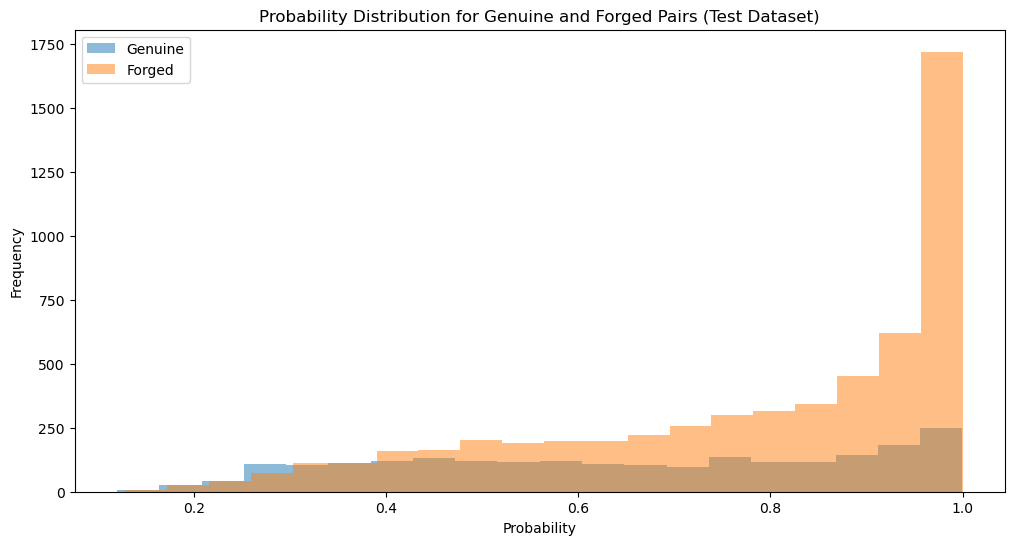

In [ ]:
criterion = nn.BCELoss()  #Binary Cross-Entropy Loss

# Initialize lists to store outputs, labels, and losses
probabilities = []
labels = []
losses = []

# Loop through the test data
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data  # x0 and x1 are input pairs, label indicates "Genuine" (0) or "Forged" (1)
    label = label.to(device).float()  # Ensure labels are in float for BCELoss

    # Forward pass through the model
    prob = model(x0.to(device), x1.to(device))  # Output probability (after sigmoid)
    prob = prob.squeeze()  # Remove extra dimensions if any
    label = label.squeeze()  # Remove extra dimensions from the target

    # Calculate Binary Cross-Entropy Loss
    loss = criterion(prob, label).item()  # Loss for the batch

    # Store probabilities, labels, and losses
    probabilities.append(prob.item())  # Append the single float probability
    labels.append(label.item())  # Append the single float label
    losses.append(loss)

# Create a DataFrame for analysis
results_df = pd.DataFrame({
    "Probability": probabilities,
    "Label": ["Genuine" if lbl == 0 else "Forged" for lbl in labels],
    "Loss": losses
})

# Calculate statistics for genuine and forged pairs
genuine_stats = results_df[results_df["Label"] == "Genuine"][["Probability", "Loss"]].describe()
forged_stats = results_df[results_df["Label"] == "Forged"][["Probability", "Loss"]].describe()

# Print statistics
print("Genuine Pair Statistics:\n", genuine_stats)
print("\nForged Pair Statistics:\n", forged_stats)

# Optional: Plot histograms of probabilities
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(results_df[results_df["Label"] == "Genuine"]["Probability"], bins=20, alpha=0.5, label="Genuine", color="blue")
plt.hist(results_df[results_df["Label"] == "Forged"]["Probability"], bins=20, alpha=0.5, label="Forged", color="red")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Probability Distribution for Genuine and Forged Pairs (Test Dataset)")
plt.legend()
plt.show()


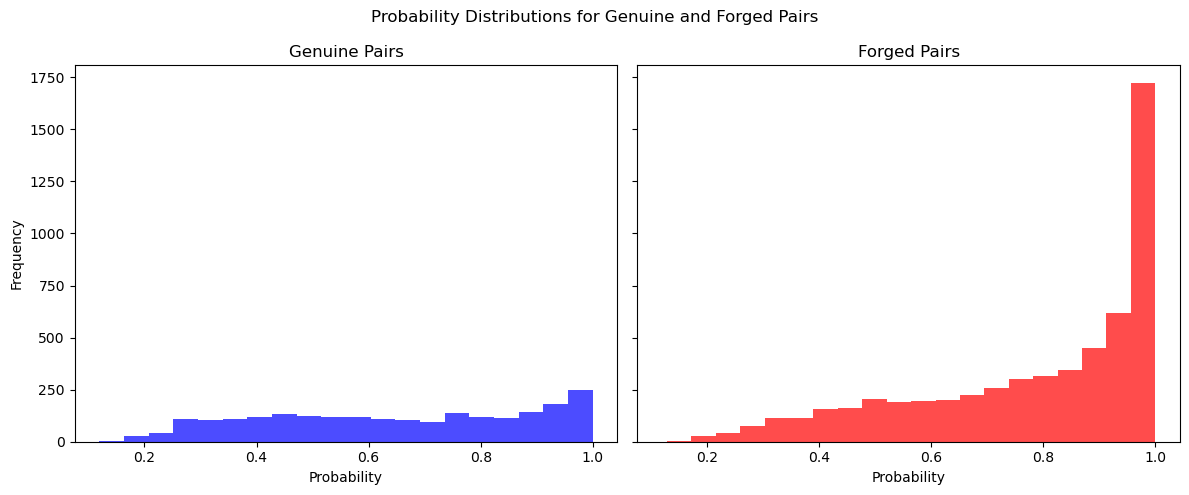

In [56]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot histogram for Genuine Pairs
axes[0].hist(results_df[results_df["Label"] == "Genuine"]["Probability"], bins=20, alpha=0.7, color="blue")
axes[0].set_title("Genuine Pairs")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Frequency")

# Plot histogram for Forged Pairs
axes[1].hist(results_df[results_df["Label"] == "Forged"]["Probability"], bins=20, alpha=0.7, color="red")
axes[1].set_title("Forged Pairs")
axes[1].set_xlabel("Probability")

# Adjust layout for better spacing
plt.suptitle("Probability Distributions for Genuine and Forged Pairs")
plt.tight_layout()
plt.show()